In [1]:
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch as T
import torch.nn as nn
from torch import optim
from tensorboardX import SummaryWriter

from training.train_utils import dseg_train_epoch, dseg_val_epoch
from datagenerator import generate_data, SynthSignalsDataset, get_params_from_json
from model import UNet1SnC # Unet1SnC: has a 1D UNet with a modest number of params and channels

In [9]:
def train_model(train_ldr, val_ldr, net, device, epochs, batch_size, lr, Loggers, save_cp=True):
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    # Using MSE Loss for Training
    criterion = nn.MSELoss()
    
    lowest_v_L = -1
    for epoch in tqdm(range(epochs)):
        
        t_loss = dseg_train_epoch(net, train_ldr, criterion, optimizer, device) 
        v_loss = dseg_val_epoch(net, val_ldr, criterion, device)
        
        scheduler.step()

        if 'WandB' in Loggers:
            wandb.log({'Train Loss': t_loss,'Val. Loss': v_loss})
        
        if 'TB' in Loggers:
            writer.add_scalars('Losses',{
                'Train Loss': t_loss,
                'Val. Loss': v_loss,
            }, epoch)
        
    
    writer.close()
    
    state_dict = net.state_dict()
    T.save(state_dict, './savedmodels/model'+f'Final.pth')


def dseg_signal(x, net, device):
    """
    Predicts the segmentation of the input signal using the trained model.
    """
    with T.no_grad():
        x = x.to(device)
        net.eval()
        outputs = net(x)
        pout = outputs[0].cpu().numpy().squeeze()
        wsout = outputs[1].cpu().numpy().squeeze()

        return pout, wsout


In [3]:
# Loggers = ['WandB','TB']
Loggers = ['TB']
N_t = 3000 # Number of training samples
N_v = 32 # Number of samples used in validation
epochs = 100
lr = 0.0001

# This tries to find a useful accelerator to use:
if T.cuda.is_available():
    device = "cuda"
elif T.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

T.device(device)
print("Using device:", device)

if 'TB' in Loggers:
    writer = SummaryWriter() # Using TBX for logging

if 'WandB' in Loggers:
    wandb.login() # Using wandb for visualising results

# if a directory for saving models does not exist, create it
if not os.path.exists('./savedmodels'):
    os.makedirs('./savedmodels')

# if a directory for saving figures does not exist, create it
if not os.path.exists('./Figures'):
    os.makedirs('./Figures')


Using device: mps


In [4]:
params = get_params_from_json('./Parameters/params.json')
params['noise_level'] = 0.2 # Sigma - uniform Gaussian SD = 0.2
params['randomoffset'] = False

train_ds = SynthSignalsDataset(params, num_samples=N_t, device=device)
val_ds = SynthSignalsDataset(params, num_samples=N_v, device=device)

train_ldr = T.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

val_ldr =  T.utils.data.DataLoader(val_ds, batch_size=32, shuffle=True)

net = UNet1SnC(n_channels=1, n_classes=6)
net.to(device)


if 'WandB' in Loggers:
    training_run = wandb.init(
        # Set the project where this run will be logged
        project="onedseg",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": epochs,
        },
    )

train_model(train_ldr, val_ldr, net, device, epochs, batch_size=32, lr=lr, Loggers=Loggers)

if 'WandB' in Loggers:
    wandb.finish()

100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


## Testing of the network

In [5]:
sns.set_theme(style='white')
sns.set(rc={'figure.figsize':(10,6)}, font_scale=2.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

plt.rcParams.update({
    "text.usetex": True,
})

In [12]:
from datagenerator import makesignal
params['noise_level'] = 0.2 # Sigma - uniform Gaussian SD = 0.0

x_tmp, gt, signalclass = makesignal(params)
x_tmp_exp = x_tmp[:,None]
x = T.tensor(x_tmp_exp, dtype=T.float32).to(device)
out, ws = dseg_signal(x, net, device)

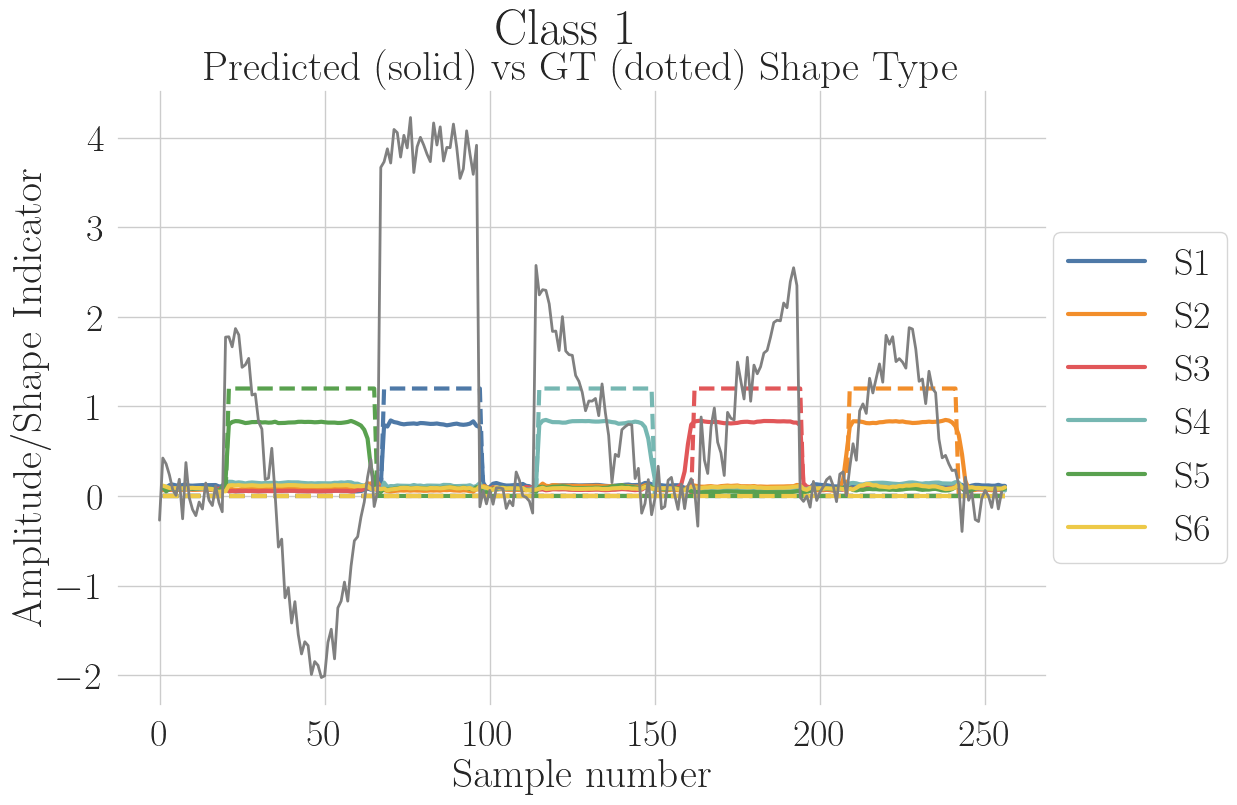

In [13]:
fig = plt.figure(figsize=(12,8))
ax = plt.gca()

# Modern color palette (Tableau 10)
colours = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']

ShapeLikelihood = np.transpose(out)

for i in range(ShapeLikelihood.shape[1]):
    plt.plot(np.arange(1,257), 1.2*gt[:,i], ls='--', lw=3, color=colours[i])

    plt.plot(np.arange(1,257), ShapeLikelihood[:,i], lw=3, color=colours[i])

plt.plot(x_tmp[0], ls='-', lw=2, color='#808080')

# Create a custom legend for the six classes
legend_handles = [plt.Line2D([0], [0], color=col, lw=3) for col in colours]
plt.legend(legend_handles, ['S1', 'S2', 'S3', 'S4', 'S5', 'S6'], bbox_to_anchor=(1.1, 0.5), loc='center')

# Add labels and title
plt.xlabel('Sample number')
plt.ylabel('Amplitude/Shape Indicator')
plt.title('Predicted (solid) vs GT (dotted) Shape Type')
plt.suptitle('Class ' + str(signalclass))

# Save the plot
plt.savefig('DensePredictions.svg')